In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, laplace, beta
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import warnings 
import pystan
import arviz
warnings.filterwarnings('ignore')

# MCMC a pravděpodobnostní programování - studie

V tomto notebooku si ukážeme několik příkladů pravděpodobnostního programování. Budeme používat bayesovský aparát. V zásadě budeme postupovat vždy ve třech krocích:
1. Sestavíme odpovídající model pro studovaný problém. Modelem je pravděpodobnostní distribuce, resp. její hustota.
2. Zvolíme vhodné apriorní distribuce pro odhad neznámých parametrů zvoleného modelu.
3. S využitím dostupných dat provedeme odhad parametrů a ex-post analýzy.

K odhadu budeme využívat [*stan*](https://mc-stan.org) resp. jeho pythoní interface [*pystan*](https://pystan.readthedocs.io). Odhadování parametrů bude realizováno pomocí MCMC, jež jsme probrali minule. Na vizualizaci použijeme knihovnu [*arviz*](https://arviz-devs.github.io/arviz/notebooks/Introduction.html).

## Odhad střední hodnoty normálního rozdělení

Nasimulujme si nejprve data z normálního rozdělení 

$$
y \sim \mathcal{N}(\mu, \sigma^2), \qquad \mu=1.5, \sigma=5.
$$

Pro zajímavost se podívejme na průměr, který je frekventistickým odhadem střední hodnoty 1.5.

In [2]:
mean = 1.5
std = 5
ndat = 1000

x = norm.rvs(loc=mean, scale=std, size=ndat)
print(f'Sample mean: {x.mean():.4f}')

Sample mean: 1.4071


Nyní je naším cílem provést odhad $\mu$ při známém rozptylu $\sigma^2$. K tomu použijeme normální apriorní distribuci, v kódu níže $\mu \sim \mathcal{N}(0, 10)$.

Pro využití *stanu* musíme nadefinovat celý náš model. Definice se skládá z těchto bloků:
- *data*: specifikace dat (pozorování, měření), která k odhadu použijeme. V tomto příkladu výše vygenerovaná proměnná `x`, musíme uvést typ, rozměry a omezení.
- *transformed_data*: zde nepoužijeme. Někdy se vyplatí data transformovat a inferenci dělat až poté.
- *parameters*: specifikace odhadovaných proměnných, tj. parametrů modelu, v našem příkladu $\mu$. Uvádí se typ, rozměry a omezení.
- *transformed_parameters*: v některých případech (např. v regresi) je výhodné pracovat i s tranformovanými parametry.
- *model*: pravděpodobnostní podoba modelu, tj. jaké jsou distribuce pro pozorovaná data (v našem příkladu $x$) a apriorní distribuce pro parametry (v našem příkladu $\mu$).
- *generated_quantities*: vygenerované veličiny, které nejsou využity v pravděpodobnostním modelu.

*Data* a *parameters*, vč. transformovaných, jsou globální a může k nim být přistupováno ze všech ostatních bloků. Na druhé straně, co je zavedeno v *model* a *generated quantities*, je lokální.

Definice slouží pro překlad do C++, proto nese některé jeho charakteristiky (typování apod.).

In [3]:
model_code = """
data {
    int<lower=0> N;      // number of data items
    vector[N] x;         // data (observations)
    real<lower=0> std;   // standard deviation 
}

parameters {
    real mu;             // estimated mean
}

model {
    mu ~ normal(0, 10);  // prior for the mean
    x ~ normal(mu, std); // data model
}
"""

Nyní už "pythonovsky" zadefinujeme dictionary ve kterém specifikujeme konkrétní hodnoty pro výše zavedená `data` a pustíme překlad:

In [4]:
data = {
    'x': x,
    'std': std,
    'N': ndat
}


sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_51fd015162c38c06a3c5b6d5557744b8 NOW.


Po kompilaci, jež může chvilku trvat, je možné spustit fitování modelu. Nebudeme zde rozebírat možné fitovací algoritmy, zmiňme jen tyto parametry:
- `iter` - počet iterací (MCMC kroků),
- `warmup` - délka burn-in, tj. zahozených počátečních vzorků
- `thin` - thinning
- `chains` - počet řetězců
- `verbose` - `True` bude vypisovat nějaké potenciálně zajímavé výstupy na STDIN.

In [5]:
fit = sm.sampling(data=data, iter=3000, warmup=1000, thin=2, chains=2, verbose=True)

Výsledný objekt `fit` obsahuje vygenerovaný řetězec atd. Ve `__str__` najdeme popis fitovací procedury a pro proměnnou `mu` průměr (lze použít jako bodový odhad $\mu$), směrodatnou odchylku aposteriorní distribuce, kvantily aposteriorní distribuce, počet efektivních vzorků (`n_eff` - ESS, effective sample size) a statistiku $\hat{R}$. Připomeňme, že kvantily 2.5% a 97.5% obvykle používáme na vymezení 95% [(bayesovského) intervalu spolehlivosti](https://en.wikipedia.org/wiki/Credible_interval).

`lp__` je logaritmus aposteriorní distribuce (log-posterior).

In [6]:
print(fit)

Inference for Stan model: anon_model_51fd015162c38c06a3c5b6d5557744b8.
2 chains, each with iter=3000; warmup=1000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     1.41  5.0e-3   0.16   1.08   1.31   1.41   1.52   1.72   1012    1.0
lp__ -475.1    0.02   0.71 -477.1 -475.3 -474.8 -474.6 -474.6   1345    1.0

Samples were drawn using NUTS at Mon May 11 19:47:08 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Prvotní posouzení konvergence umožňují právě `Rhat` a `n_ess`:
- `Rhat`, též Gelmanova-Rubinova diagnostika kombinuje informaci o variabilitě v rámci řetězce a mezi řetězci. Zjednodušeně řečeno tím říká, zda každý řetězec (chain) dokonvergoval ke stacionární distribuci a zda jsou tyto distribuce stejné pro všechny řetězce. Jako pravidlo dobré konvergence se uvažuje $\hat{R} < 1.1$.
- `n_eff`, počet efektivních vzorků (effective sample size), indikuje, zda řetězce dostatečně dobře "prozkoumaly" aposteriorní hustotu. Nízká hodnota vypovídá o vysokých autokorelacích v rámci řetězců - viz minulý notebook. Obvykle se požaduje, aby byl aspoň jeden efektivní vzorek z 1000 v rámci post-burn-in vzorkování, toto číslo je ovšem i tak velmi daleko od ideálu, neboť je nutné takový řetězec nechat běžet příliš mnoho iterací.

Pokud je některá z hodnot hraniční nebo nevyhovující, STAN nás upozorní.

Pro další diagnostiku můžeme použít balík *arviz*. Ten umí vykreslit spoustu různých grafů, podívejme se na některé z nich. Nejprve si ale připravíme "arvizí" reprezentaci dat:

In [7]:
trace = fit.extract()
inferencedata = arviz.from_pystan(posterior=fit)

Nejprve traceplot a jádrový odhad tvaru aposteriorní hustoty pro $\mu$. Pro naše požadavky na traceplot viz minulý notebook (soustředíme se hlavně na trend a výskyt period s konstantní hodnotou).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9318faffa0>,
      dtype=object)

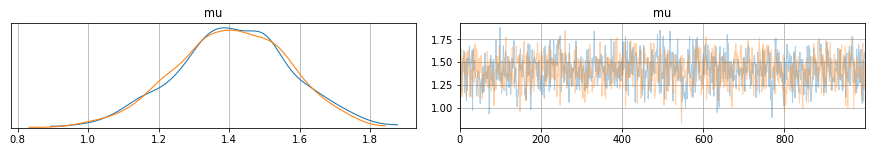

In [8]:
arviz.plot_trace(inferencedata)

Vykreslíme si ještě autokorelační funkci. Naším ideálem je, aby autokorelace byly co nejmenší.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9314d74f10>]],
      dtype=object)

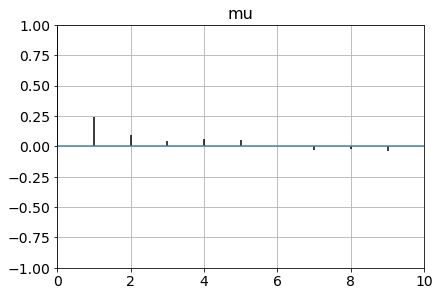

In [9]:
arviz.plot_autocorr(inferencedata, max_lag=10, combined=True)

**Úkol: zkuste měnit nastavení sampleru a sledujte, co to dělá s výsledky a grafy.**

### Stejná data: Odhad $\mu$ i $\sigma$

Použijme ještě jednou výše vygenerovaná data a pokusme se odhadnout kromě $\mu$ i $\sigma$. Jako apriorní distribuci pro $\sigma$ použijme např. gama rozdělení (potřebujeme nějaké definované na kladné poloose!). Výsledný model s nějak rozumně zvolenými hyperparametry apriorních distribucí pak vypadá třeba takto:

$$
\begin{aligned}
x &\sim \mathcal{N}(\mu, \sigma^2), \\
\mu &\sim \mathcal{N}(0, 10^2), \\
\sigma &\sim \mathcal{G}(2, 0.1).
\end{aligned}
$$

In [10]:
model_code = """
data {
    int<lower=0> N;      // number of data items
    vector[N] x;         // data (observations)
}

parameters {
    real mu;             // estimated mean
    real<lower=0> std;   // estimated standard dev.
}

model {
    mu ~ normal(0, 10);  // prior for the mean
    std ~ gamma(2, 0.1); // prior for st. dev.
    x ~ normal(mu, std); // data model
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b91cd30c77926cedee55891823016a7e NOW.


Další postup je podobný jako v předchozím příkladě:

In [11]:
data = {
    'x': x,
    'N': ndat
}

In [12]:
fit = sm.sampling(data=data, iter=3000, warmup=1000, thin=2, chains=2, verbose=True)

In [13]:
print(fit)

Inference for Stan model: anon_model_b91cd30c77926cedee55891823016a7e.
2 chains, each with iter=3000; warmup=1000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     1.41  3.5e-3   0.15   1.12    1.3   1.41   1.52   1.71   1929    1.0
std    4.88  2.5e-3   0.11   4.68    4.8   4.87   4.95   5.09   1791    1.0
lp__  -2081    0.02   0.95  -2084  -2082  -2081  -2081  -2080   1608    1.0

Samples were drawn using NUTS at Mon May 11 19:48:07 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [14]:
trace = fit.extract()
inferencedata = arviz.from_pystan(posterior=fit)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9314bac220>,
      dtype=object)

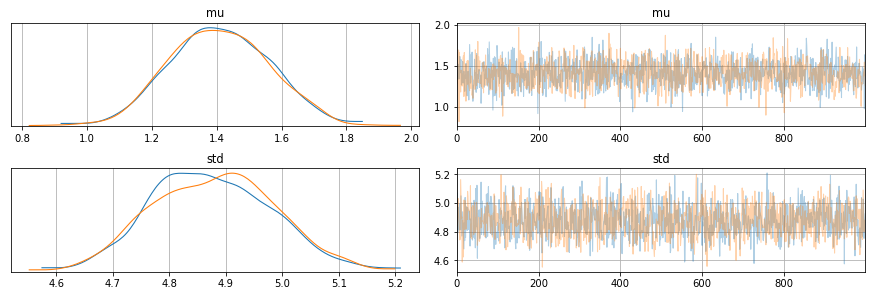

In [15]:
arviz.plot_trace(inferencedata)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93191161f0>,
      dtype=object)

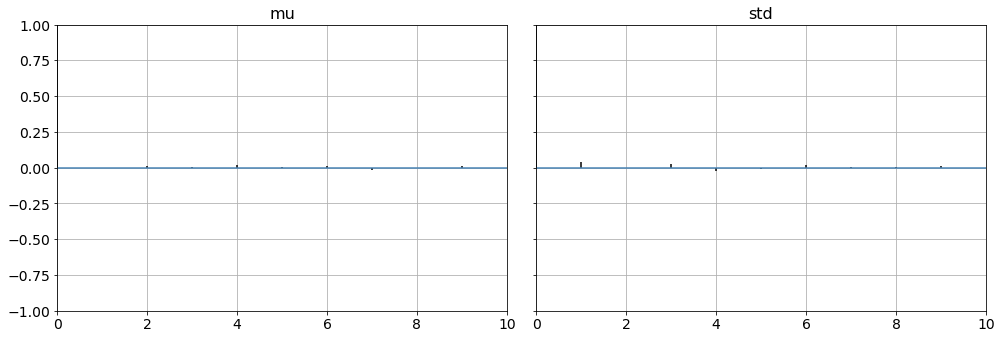

In [16]:
arviz.plot_autocorr(inferencedata, max_lag=10, combined=True)

# Lineární regrese

Podívejme se na odhad koeficientů lineárního regresního modelu a odhad variance (resp. směrodatné odchylky) šumu. Lineární regresní model známe už z dřívějších přednášek a víme, že bychom mohli použít konjugované apriorno v podobě normální inverzní-gama distribuce.

Model skalárního reálného $y_i$ má tvar

$$
y_i = x_i^\intercal \beta + \varepsilon_i, \qquad \varepsilon_i \sim \mathcal{N}(0,\sigma^2),
$$

kde $\beta\in\mathbb{R}^K$ je vektor regresních koeficientů, $x_i\in\mathbb{R}^K$ je regresor a $i=1,\ldots,N$.

Nasimulujeme si nějaká data:

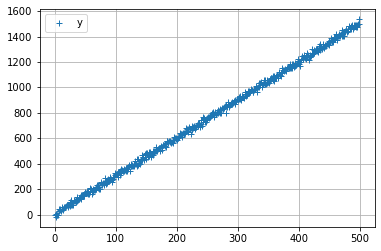

In [17]:
ndat = 500
x = np.arange(ndat)
beta = np.array([5.4, 3])
X = np.c_[np.ones((ndat,1)), x]
y = X.dot(beta) + norm.rvs(loc=0, scale=15, size=ndat)

plt.plot(y, '+', label='y')
plt.legend()

Odhadovat chceme $\beta$ a $\sigma$. Můžeme použít např. normální distribuci pro odhad první veličiny a např. gama distribuci pro druhou, tj.

$$
\begin{aligned}
y_i &\sim \mathcal{N}(x_i^\intercal \beta, \sigma^2),\\
\beta &\sim \mathcal{N}(\beta_0, \Sigma_0),\\
\sigma &\sim \mathcal{G}(2, 0.1). \\
\end{aligned}
$$

Hyperparametry $\beta_0$ a $\Sigma_0$ v podobě proměnných `beta0` a `Sigma0` můžeme chtít nastavovat až při samplování :)

In [18]:
data_code = """
data {
    int<lower=0> N;       // number of observations
    int<lower=0> K;       // number of regressors
    matrix[N, K] X;       // design matrix
    vector[N] y;          // observations vector
    vector[K] beta0;      // prior hyperparameter to be set externally
    cov_matrix[K] Sigma0; // prior hyperparameter to be set externally
}

parameters {
    vector[K] beta;       // coefficients for predictors
    real<lower=0> sigma;  // noise st. dev.
}

model {
    beta ~ multi_normal(beta0, Sigma0); // prior for beta
    sigma ~ gamma(2, 0.1);              // prior for sigma
    y ~ normal(X * beta, sigma);        // model pdf
}
"""

sm = pystan.StanModel(model_code=data_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1adba6e8557889464358a4feb0258d51 NOW.


Sestavíme si data a pustíme sampling, jak už jsme zvyklí:

In [19]:
data = {
    'X': X,
    'N': X.shape[0],
    'K': X.shape[1],
    'y': y,
    'beta0': np.zeros(X.shape[1]),
    'Sigma0': np.eye(X.shape[1]) * 10
}

In [20]:
fit = sm.sampling(data=data, iter=5000, warmup=1000, thin=2, chains=3, verbose=True)

Podívejme se na výsledky. Jaké byly skutečné koeficienty $\beta$ a skutečná směrodatná odchylka šumu víme z příkladu výše

In [21]:
print(fit)

Inference for Stan model: anon_model_1adba6e8557889464358a4feb0258d51.
3 chains, each with iter=5000; warmup=1000; thin=2; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   5.65    0.02    1.2   3.31   4.81   5.65   6.48   8.01   4633    1.0
beta[2]    3.0  6.1e-5 4.2e-3   2.99    3.0    3.0    3.0   3.01   4674    1.0
sigma    14.41  6.4e-3   0.46  13.57   14.1   14.4  14.71  15.35   5062    1.0
lp__     -1581    0.02    1.2  -1584  -1582  -1581  -1580  -1580   3942    1.0

Samples were drawn using NUTS at Mon May 11 19:49:12 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [22]:
trace = fit.extract()
inferencedata = arviz.from_pystan(posterior=fit)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9318cb41f0>,
      dtype=object)

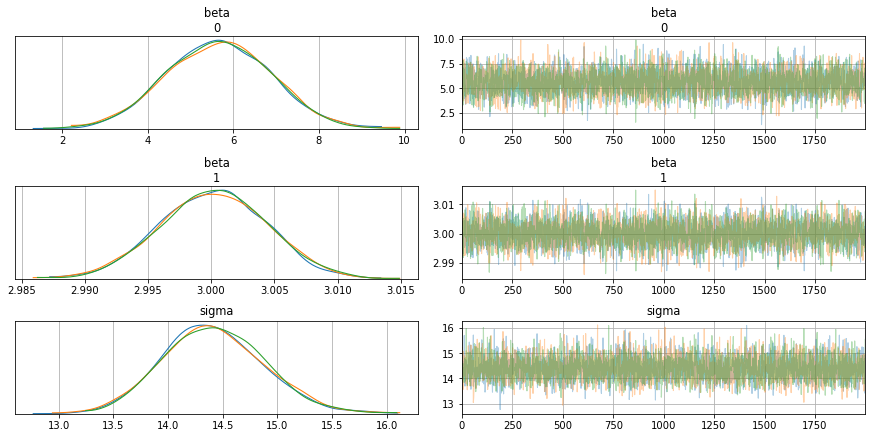

In [23]:
arviz.plot_trace(inferencedata)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f931490c5b0>,
      dtype=object)

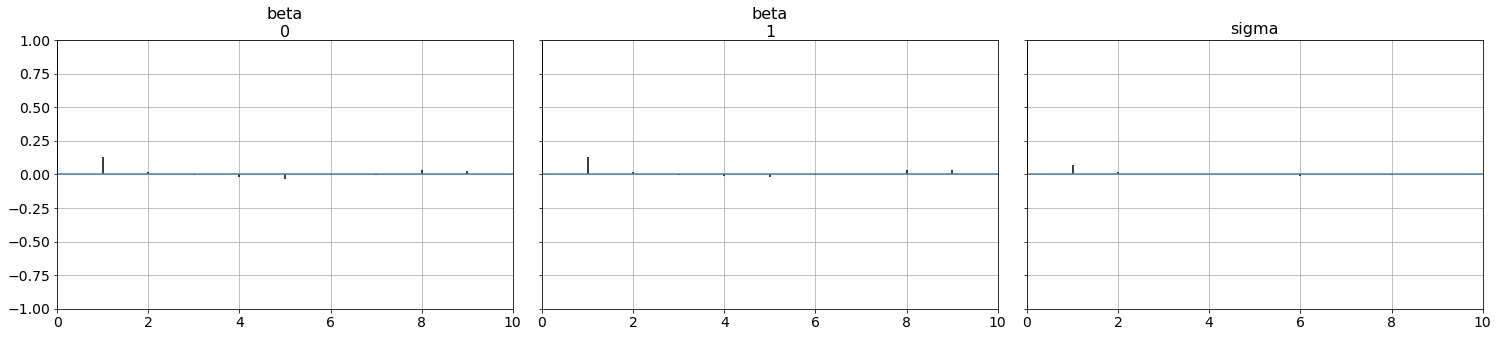

In [24]:
arviz.plot_autocorr(inferencedata, max_lag=10, combined=True)

Podívejme se ze zvědavosti, jak by dopadl MLE odhad

$$
\hat{\beta} = (X^\intercal X)^{-1}X^\intercal y,
$$

kde $X$ je návrhová matice ([design matrix](https://en.wikipedia.org/wiki/Design_matrix)), obsahující regresory v řádcích:

Estimate of beta: [6.60328618 2.99725278]


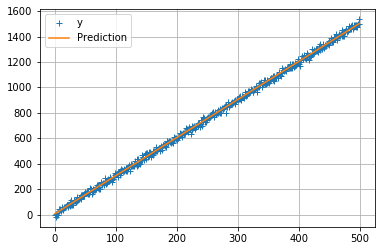

In [25]:
XTX_inv = np.linalg.inv(np.dot(X.T, X))
XTy = np.dot(X.T, y)
beta_hat = XTX_inv.dot(XTy)
print(f"Estimate of beta: {beta_hat}")
plt.plot(y, '+', label='y')
plt.plot(X.dot(beta_hat), label='Prediction')
plt.legend()

Výše uvedená regrese pomocí STANu je bohužel v jisté míře naivní. S rostoucím počtem dimenzí a výrazně se lišícími hodnotami ve vektoru $\beta$ může sampler zabloudit. Proto je výhodné využít na začátku notebooku zmíněné reparametrizační bloky a sampleru "pomoci". V případě lineární regrese ve STANu je preferovanou reparametrizací [QR reparametrizace](https://mc-stan.org/docs/2_18/stan-users-guide/QR-reparameterization-section.html).

## Závěrem

STAN využívá při výpočtech [Hamiltonovské Monte Carlo](https://mc-stan.org/docs/2_23/reference-manual/hamiltonian-monte-carlo.html), HMC. To je jednou z variant klasického MCMC algoritmu představeného v minulém notebooku. Podobných variant vznikla za účelem zefektivnění vzorkovacího procesu celá řada.

STAN, podobně jako [PyMC3](https://docs.pymc.io) lze použít k nepřebernému množství modelářských úloh. Je však dobré na to nespoléhat úplně slepě. Zkusíte-li např. naivní implementaci lineární regrese, zjistíte, že sampler snadno zabloudí. Využití výsledků potom zdaleka nevede k úspěchu. Je proto důležité nad problémy dostatečně přemýšlet, zvážit, jaká použít apriorna, zda by nebylo lepší použít apriorna konjugovaná (zvl. v online problémech). S obrovským nárůstem výpočetního výkonu počítačů to někdy vypadá, že uživatelé se vyhýbají "ručnímu" řešení i vcelku triviálních úloh a slepě přenechávají veškerou práci počítači. Jenže pak se někdy nestačí divit...